TODAY

In [24]:
from datetime import datetime

# Get today's date in 'YYYY-MM-DD' format
today_date = datetime.today().strftime('%Y-%m-%d')
print(today_date)

2025-05-25


Finance Data

In [25]:
import yfinance as yf

# Define parameters
symbol = 'IBM'
start_date = '2000-01-01'
end_date = today_date
output_filename = f'{symbol}_daily_data.csv'

# Download data (make sure to not pass a list)
data = yf.download(symbol, start=start_date, end=end_date, interval='1d')

# Reset index to make 'Date' a column
data.reset_index(inplace=True)

# Save to clean CSV
data.to_csv(output_filename, index=False)



[*********************100%***********************]  1 of 1 completed


In [26]:
import pandas as pd
df = pd.read_csv(output_filename)
# Remove the first row (header row mistakenly read as data)
df = df.iloc[1:].reset_index(drop=True)

# Save the cleaned dataframe back to CSV
df.to_csv(output_filename, index=False)

Training an LSTM Model with Stock Data

In [27]:
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dropout, Dense
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import matplotlib.pyplot as plt

In [28]:
# Load your CSV (must have 'Close' column)
df = pd.read_csv(output_filename)

# Ensure only numerical data
data = df[['Close']].dropna().values

In [29]:
# Scale the data
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(data)

In [30]:
# Create sequences
def create_sequences(data, time_steps=60):
    X, y = [], []
    for i in range(time_steps, len(data)):
        X.append(data[i - time_steps:i])
        y.append(data[i])
    return np.array(X), np.array(y)

time_steps = 60  # e.g. 60 days
X, y = create_sequences(scaled_data, time_steps)

In [31]:
# Train-test split
split = int(len(X) * 0.8)
X_train, y_train = X[:split], y[:split]
X_test, y_test = X[split:], y[split:]

# Build the LSTM model
model = Sequential()
model.add(LSTM(128, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(0.3))
model.add(LSTM(64, return_sequences=True))
model.add(Dropout(0.3))
model.add(LSTM(32))
model.add(Dropout(0.3))
model.add(Dense(1))

# Compile
model.compile(optimizer='adam', loss='mean_squared_error')

# Callbacks
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
checkpoint = ModelCheckpoint('best_model.h5', save_best_only=True)



/workspaces/Stock-Market-Prediction-AI-Model/myenv/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [32]:
# Train
history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=100,
    batch_size=32,
    callbacks=[early_stop, checkpoint],
    verbose=1
)

# Predict
predictions = model.predict(X_test)
predictions = scaler.inverse_transform(predictions)
y_test_rescaled = scaler.inverse_transform(y_test)

# Evaluate
mae = mean_absolute_error(y_test_rescaled, predictions)
mse = mean_squared_error(y_test_rescaled, predictions)
r2 = r2_score(y_test_rescaled, predictions)
print(f'MAE: {mae:.4f}, MSE: {mse:.4f}, R²: {r2:.4f}')



Epoch 1/100
158/159 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - loss: 0.0061

159/159 ━━━━━━━━━━━━━━━━━━━━ 13s 63ms/step - loss: 0.0061 - val_loss: 0.0078
Epoch 2/100
158/159 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - loss: 9.4130e-04

159/159 ━━━━━━━━━━━━━━━━━━━━ 10s 60ms/step - loss: 9.4051e-04 - val_loss: 0.0053
Epoch 3/100
158/159 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - loss: 8.8296e-04

159/159 ━━━━━━━━━━━━━━━━━━━━ 9s 59ms/step - loss: 8.8219e-04 - val_loss: 0.0028
Epoch 4/100
158/159 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - loss: 6.7112e-04

159/159 ━━━━━━━━━━━━━━━━━━━━ 10s 60ms/step - loss: 6.7086e-04 - val_loss: 0.0027
Epoch 5/100
159/159 ━━━━━━━━━━━━━━━━━━━━ 9s 59ms/step - loss: 5.7758e-04 - val_loss: 0.0032
Epoch 6/100
159/159 ━━━━━━━━━━━━━━━━━━━━ 10s 63ms/step - loss: 5.1880e-04 - val_loss: 0.0038
Epoch 7/100
159/159 ━━━━━━━━━━━━━━━━━━━━ 10s 59ms/step - loss: 4.5102e-04 - val_loss: 0.0030
Epoch 8/100
158/159 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - loss: 4.1548e-04

159/159 ━━━━━━━━━━━━━━━━━━━━ 9s 60ms/step - loss: 4.1516e-04 - val_loss: 0.0013
Epoch 9/100
159/159 ━━━━━━━━━━━━━━━━━━━━ 9s 58ms/step - loss: 4.1293e-04 - val_loss: 0.0018
Epoch 10/100
159/159 ━━━━━━━━━━━━━━━━━━━━ 10s 61ms/step - loss: 3.6429e-04 - val_loss: 0.0027
Epoch 11/100
159/159 ━━━━━━━━━━━━━━━━━━━━ 9s 59ms/step - loss: 3.5875e-04 - val_loss: 0.0016
Epoch 12/100
159/159 ━━━━━━━━━━━━━━━━━━━━ 10s 60ms/step - loss: 3.3596e-04 - val_loss: 0.0019
Epoch 13/100
159/159 ━━━━━━━━━━━━━━━━━━━━ 9s 60ms/step - loss: 3.1306e-04 - val_loss: 0.0013
Epoch 14/100
158/159 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - loss: 3.3756e-04

159/159 ━━━━━━━━━━━━━━━━━━━━ 10s 61ms/step - loss: 3.3732e-04 - val_loss: 7.5389e-04
Epoch 15/100
159/159 ━━━━━━━━━━━━━━━━━━━━ 10s 60ms/step - loss: 3.1807e-04 - val_loss: 7.7872e-04
Epoch 16/100
159/159 ━━━━━━━━━━━━━━━━━━━━ 10s 61ms/step - loss: 3.2226e-04 - val_loss: 0.0021
Epoch 17/100
159/159 ━━━━━━━━━━━━━━━━━━━━ 10s 60ms/step - loss: 3.1751e-04 - val_loss: 8.8514e-04
Epoch 18/100
159/159 ━━━━━━━━━━━━━━━━━━━━ 10s 61ms/step - loss: 3.0049e-04 - val_loss: 0.0014
Epoch 19/100
159/159 ━━━━━━━━━━━━━━━━━━━━ 10s 62ms/step - loss: 3.1565e-04 - val_loss: 9.3595e-04
Epoch 20/100
159/159 ━━━━━━━━━━━━━━━━━━━━ 10s 60ms/step - loss: 3.0793e-04 - val_loss: 0.0014
Epoch 21/100
159/159 ━━━━━━━━━━━━━━━━━━━━ 10s 60ms/step - loss: 3.0494e-04 - val_loss: 9.0407e-04
Epoch 22/100
159/159 ━━━━━━━━━━━━━━━━━━━━ 10s 60ms/step - loss: 3.2345e-04 - val_loss: 8.1464e-04
Epoch 23/100
158/159 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - loss: 3.2388e-04

159/159 ━━━━━━━━━━━━━━━━━━━━ 10s 61ms/step - loss: 3.2364e-04 - val_loss: 4.4078e-04
Epoch 24/100
159/159 ━━━━━━━━━━━━━━━━━━━━ 9s 59ms/step - loss: 3.0043e-04 - val_loss: 5.1211e-04
Epoch 25/100
159/159 ━━━━━━━━━━━━━━━━━━━━ 9s 60ms/step - loss: 3.1811e-04 - val_loss: 0.0020
Epoch 26/100
159/159 ━━━━━━━━━━━━━━━━━━━━ 10s 60ms/step - loss: 3.0351e-04 - val_loss: 0.0011
Epoch 27/100
159/159 ━━━━━━━━━━━━━━━━━━━━ 10s 60ms/step - loss: 2.8146e-04 - val_loss: 0.0013
Epoch 28/100
159/159 ━━━━━━━━━━━━━━━━━━━━ 10s 61ms/step - loss: 3.0243e-04 - val_loss: 0.0014
Epoch 29/100
159/159 ━━━━━━━━━━━━━━━━━━━━ 10s 60ms/step - loss: 3.0196e-04 - val_loss: 5.1732e-04
Epoch 30/100
158/159 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - loss: 2.7820e-04

159/159 ━━━━━━━━━━━━━━━━━━━━ 10s 61ms/step - loss: 2.7823e-04 - val_loss: 3.9788e-04
Epoch 31/100
159/159 ━━━━━━━━━━━━━━━━━━━━ 10s 61ms/step - loss: 3.0792e-04 - val_loss: 7.8629e-04
Epoch 32/100
159/159 ━━━━━━━━━━━━━━━━━━━━ 10s 60ms/step - loss: 2.7284e-04 - val_loss: 8.5408e-04
Epoch 33/100
159/159 ━━━━━━━━━━━━━━━━━━━━ 10s 60ms/step - loss: 2.6844e-04 - val_loss: 0.0018
Epoch 34/100
159/159 ━━━━━━━━━━━━━━━━━━━━ 10s 60ms/step - loss: 2.8514e-04 - val_loss: 7.4422e-04
Epoch 35/100
159/159 ━━━━━━━━━━━━━━━━━━━━ 10s 61ms/step - loss: 2.8677e-04 - val_loss: 5.6698e-04
Epoch 36/100
159/159 ━━━━━━━━━━━━━━━━━━━━ 10s 60ms/step - loss: 3.1264e-04 - val_loss: 0.0014
Epoch 37/100
158/159 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - loss: 3.1283e-04

159/159 ━━━━━━━━━━━━━━━━━━━━ 10s 60ms/step - loss: 3.1261e-04 - val_loss: 3.6679e-04
Epoch 38/100
159/159 ━━━━━━━━━━━━━━━━━━━━ 9s 60ms/step - loss: 2.8433e-04 - val_loss: 6.9076e-04
Epoch 39/100
159/159 ━━━━━━━━━━━━━━━━━━━━ 9s 59ms/step - loss: 2.8926e-04 - val_loss: 4.2940e-04
Epoch 40/100
158/159 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - loss: 2.7686e-04

159/159 ━━━━━━━━━━━━━━━━━━━━ 10s 60ms/step - loss: 2.7704e-04 - val_loss: 3.3625e-04
Epoch 41/100
159/159 ━━━━━━━━━━━━━━━━━━━━ 9s 59ms/step - loss: 2.8121e-04 - val_loss: 4.5180e-04
Epoch 42/100
159/159 ━━━━━━━━━━━━━━━━━━━━ 9s 59ms/step - loss: 2.8230e-04 - val_loss: 9.1279e-04
Epoch 43/100
158/159 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - loss: 2.7830e-04

159/159 ━━━━━━━━━━━━━━━━━━━━ 9s 59ms/step - loss: 2.7824e-04 - val_loss: 3.3203e-04
Epoch 44/100
159/159 ━━━━━━━━━━━━━━━━━━━━ 9s 59ms/step - loss: 2.8359e-04 - val_loss: 8.0744e-04
Epoch 45/100
159/159 ━━━━━━━━━━━━━━━━━━━━ 9s 59ms/step - loss: 2.8766e-04 - val_loss: 0.0018
Epoch 46/100
159/159 ━━━━━━━━━━━━━━━━━━━━ 9s 59ms/step - loss: 2.7136e-04 - val_loss: 5.4189e-04
Epoch 47/100
159/159 ━━━━━━━━━━━━━━━━━━━━ 9s 58ms/step - loss: 2.9094e-04 - val_loss: 4.6709e-04
Epoch 48/100
159/159 ━━━━━━━━━━━━━━━━━━━━ 9s 58ms/step - loss: 2.9938e-04 - val_loss: 3.9491e-04
Epoch 49/100
159/159 ━━━━━━━━━━━━━━━━━━━━ 10s 60ms/step - loss: 3.2555e-04 - val_loss: 0.0012
Epoch 50/100
159/159 ━━━━━━━━━━━━━━━━━━━━ 10s 63ms/step - loss: 2.7057e-04 - val_loss: 5.2184e-04
Epoch 51/100
159/159 ━━━━━━━━━━━━━━━━━━━━ 9s 59ms/step - loss: 2.8313e-04 - val_loss: 0.0011
Epoch 52/100
159/159 ━━━━━━━━━━━━━━━━━━━━ 9s 59ms/step - loss: 2.7677e-04 - val_loss: 0.0010
Epoch 53/100
159/159 ━━━━━━━━━━━━━━━━━━━━ 9s 58ms/step - 

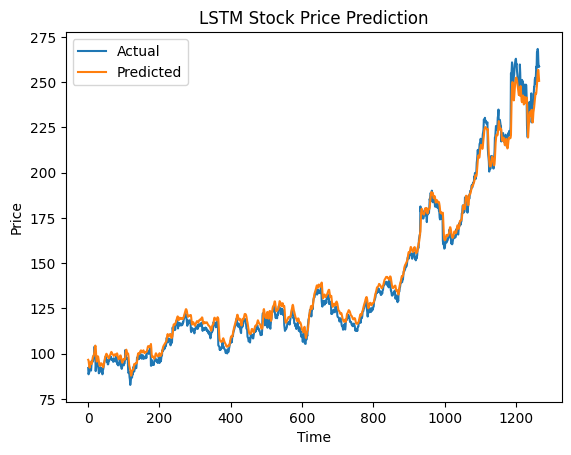

In [ ]:
# Plot results
plt.plot(y_test_rescaled, label='Actual')
plt.plot(predictions, label='Predicted')
plt.title('LSTM Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.show()

Keras Tuner

In [ ]:
from tensorflow import keras
from tensorflow.keras import layers
from keras_tuner import HyperModel

def build_model(hp):
    model = keras.Sequential()
    
    # Tune LSTM units
    model.add(layers.LSTM(
        units=hp.Int("units", min_value=32, max_value=256, step=32),
        return_sequences=True,
        input_shape=(X_train.shape[1], X_train.shape[2])
    ))
    model.add(layers.Dropout(hp.Float("dropout_1", 0.1, 0.5, step=0.1)))

    # Second LSTM layer
    model.add(layers.LSTM(
        units=hp.Int("units_2", min_value=32, max_value=128, step=32),
        return_sequences=False
    ))
    model.add(layers.Dropout(hp.Float("dropout_2", 0.1, 0.5, step=0.1)))

    model.add(layers.Dense(1))  # Output layer

    # Tune learning rate
    model.compile(
        optimizer=keras.optimizers.Adam(
            hp.Float("learning_rate", 1e-4, 1e-2, sampling="log")
        ),
        loss="mean_squared_error"
    )
    
    return model


In [35]:
from keras_tuner import RandomSearch

tuner = RandomSearch(
    build_model,
    objective="val_loss",
    max_trials=10,  # Number of different combinations to try
    executions_per_trial=1,
    directory="tuner_dir",
    project_name="stock_lstm"
)


/workspaces/Stock-Market-Prediction-AI-Model/myenv/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [36]:
tuner.search(X_train, y_train,
             epochs=20,
             batch_size=32,
             validation_data=(X_test, y_test))


Trial 10 Complete [00h 05m 05s]
val_loss: 0.09265363216400146

Best val_loss So Far: 0.00017363845836371183
Total elapsed time: 00h 32m 11s


In [37]:
best_model = tuner.get_best_models(num_models=1)[0]
best_hps = tuner.get_best_hyperparameters(1)[0]

print("Best Hyperparameters:")
print(f"Units: {best_hps.get('units')}")
print(f"Dropout 1: {best_hps.get('dropout_1')}")
print(f"Dropout 2: {best_hps.get('dropout_2')}")
print(f"Learning Rate: {best_hps.get('learning_rate')}")


Best Hyperparameters:
Units: 96
Dropout 1: 0.2
Dropout 2: 0.2
Learning Rate: 0.009411723340734904


/workspaces/Stock-Market-Prediction-AI-Model/myenv/lib/python3.12/site-packages/keras/src/saving/saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 18 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))
